In [3]:
#installing selenium for web scraping
pip install selenium
pip install selenium pandas
#note also had to download a chrome driver for my laptop in order to use selenium

SyntaxError: invalid syntax (480939520.py, line 2)

In [2]:
#adding all packages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from collections import Counter
import time
import re
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import joblib

In [ ]:
# --- SETUP ---
driver_path = "/Users/setaranusratty/Downloads/chromedriver-mac-arm64/chromedriver"
service     = Service(driver_path)
driver      = webdriver.Chrome(service=service)

# allow pages up to 30s to load
driver.set_page_load_timeout(30)
wait = WebDriverWait(driver, 20)

all_books = []

# --- LOOP OVER 20 PAGES ---
for page in range(1, 21):
    list_url = f"https://www.goodreads.com/list/show/1.Best_Books_Ever?page={page}"
    print(f"\n→ Loading list page {page}…", end=" ")
    try:
        driver.get(list_url)
    except (TimeoutException, WebDriverException):
        print("⏱ timeout on list page, skipping")
        continue

    time.sleep(2)
    links = driver.find_elements(By.CLASS_NAME, "bookTitle")
    urls  = [a.get_attribute("href") for a in links]
    print(f"found {len(urls)} books, scraping…")

    for idx, url in enumerate(urls, 1):
        try:
            driver.get(url)
            wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1[data-testid='bookTitle']")))
        except (TimeoutException, WebDriverException):
            print(f"  ⚠️ [{page}.{idx}] page load failed, skipping")
            continue

        time.sleep(1)

        # scrape fields
        title  = driver.find_element(By.CSS_SELECTOR, "h1[data-testid='bookTitle']").text.strip()
        author = driver.find_element(By.CSS_SELECTOR, "span.ContributorLink__name").text.strip()

        try:
            avg_rating = float(driver.find_element(
                By.CSS_SELECTOR, "div.RatingStatistics__rating"
            ).text.strip())
        except:
            avg_rating = None

        try:
            aria = driver.find_element(By.CSS_SELECTOR, "div.RatingStatistics__meta")\
                        .get_attribute("aria-label")
            rating_count = int(aria.split(" ratings")[0].replace(",", ""))
        except:
            rating_count = None

        try:
            pages_txt = driver.find_element(By.XPATH, "//p[contains(text(),' pages')]").text
            num_pages = int(re.search(r"(\d+)", pages_txt).group(1))
        except:
            num_pages = None

        try:
            gens   = driver.find_elements(By.CSS_SELECTOR, "span.BookPageMetadataSection__genreButton")
            genres = ", ".join(g.text for g in gens[:3])
        except:
            genres = ""

        try:
            pub_txt = driver.find_element(By.XPATH, "//p[contains(text(),'published')]").text
            m = re.search(r"(\d{4})", pub_txt)
            pub_year = int(m.group(1)) if m else None
        except:
            pub_year = None

        all_books.append({
            "title":        title,
            "author":       author,
            "avg_rating":   avg_rating,
            "rating_count": rating_count,
            "num_pages":    num_pages,
            "genres":       genres,
            "pub_year":     pub_year,
            "url":          url
        })

        if idx % 20 == 0:
            print(f"  • Scraped {idx} books on page {page}")

# clean up & save
driver.quit()
df = pd.DataFrame(all_books)
df.to_csv("/Users/setaranusratty/Desktop/goodreads_2000.csv", index=False)
print(f"\n✅ Done! Scraped {len(df)} books total.")
print(df.head())


→ Loading list page 1… found 100 books, scraping…
  • Scraped 20 books on page 1
  • Scraped 40 books on page 1
  • Scraped 60 books on page 1
  • Scraped 80 books on page 1
  • Scraped 100 books on page 1

→ Loading list page 2… found 100 books, scraping…
  • Scraped 20 books on page 2
  • Scraped 40 books on page 2
  • Scraped 60 books on page 2
  ⚠️ [2.80] page load failed, skipping
  • Scraped 100 books on page 2

→ Loading list page 3… found 100 books, scraping…
  • Scraped 20 books on page 3
  • Scraped 40 books on page 3
  • Scraped 60 books on page 3
  • Scraped 80 books on page 3
  • Scraped 100 books on page 3

→ Loading list page 4… found 100 books, scraping…
  • Scraped 20 books on page 4
  • Scraped 40 books on page 4
  • Scraped 60 books on page 4
  • Scraped 80 books on page 4
  • Scraped 100 books on page 4

→ Loading list page 5… found 100 books, scraping…
  • Scraped 20 books on page 5
  • Scraped 40 books on page 5
  • Scraped 60 books on page 5
  • Scraped 80 books

In [3]:
df = pd.read_csv("/Users/setaranusratty/Desktop/goodreads_2000.csv")

In [4]:
#to see class types and drop na
df.info()
df.head()
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1997 non-null   object 
 1   author        1997 non-null   object 
 2   avg_rating    1997 non-null   float64
 3   rating_count  1997 non-null   int64  
 4   num_pages     1992 non-null   float64
 5   genres        1993 non-null   object 
 6   pub_year      1915 non-null   float64
 7   url           1997 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 124.9+ KB


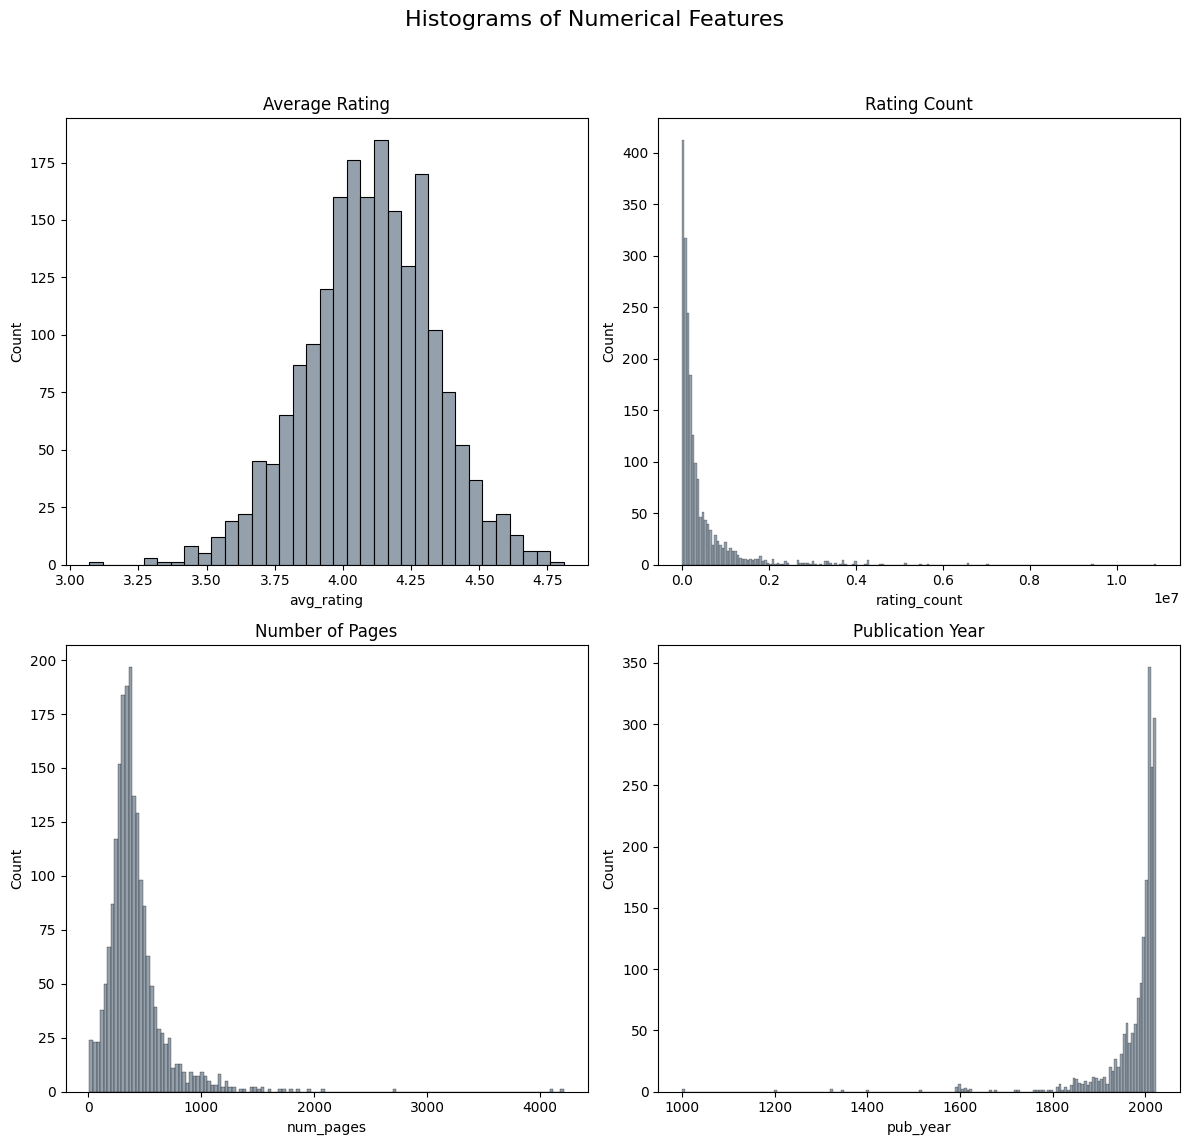

In [78]:
#getting histograms of numerical data
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Histograms of Numerical Features", fontsize=16)

axes = axes.flatten()

# Plot histograms with slategrey color
sns.histplot(df['avg_rating'], ax=axes[0], kde=False, color="slategrey").set(title='Average Rating')
sns.histplot(df['rating_count'], ax=axes[1], kde=False, color="slategrey").set(title='Rating Count')
sns.histplot(df['num_pages'], ax=axes[2], kde=False, color="slategrey").set(title='Number of Pages')
sns.histplot(df['pub_year'], ax=axes[3], kde=False, color="slategrey").set(title='Publication Year')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

want to transform rating count, num pages, and pub year since they are skewed
for the first 2 will do a log transformation, second one will subtract from 2025 to create years from publication and then log it

In [11]:
#transformed variables
df["log_rating_count"] = np.log1p(df["rating_count"])
df["log_num_pages"] = np.log1p(df["num_pages"])
df["log_pub_age"] = np.log1p(2025 - df["pub_year"])

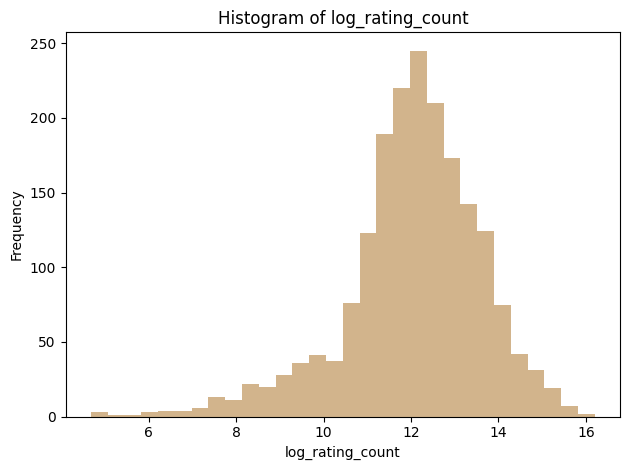

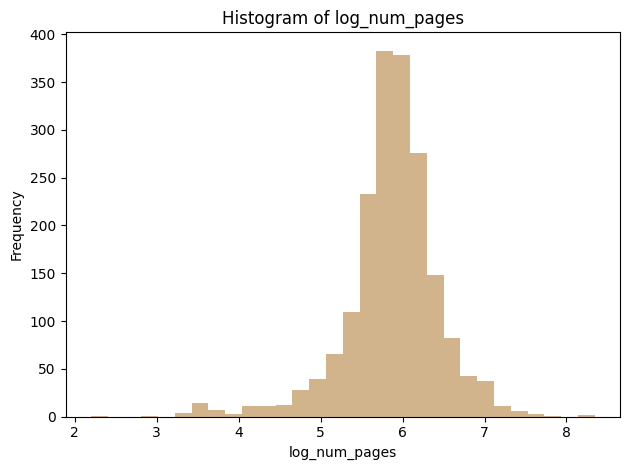

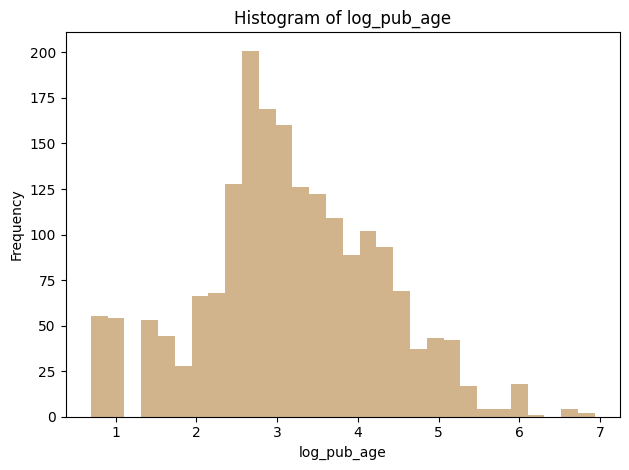

In [12]:
#replot
for col in ["log_rating_count", "log_num_pages", "log_pub_age"]:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30, color = "tan")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Looking at categorical data now specifically genres

Fiction              1220
Fantasy              558
Young Adult          460
Classics             397
Romance              354
Historical Fiction   292
Mystery              199
Science Fiction      175
Thriller             171
Contemporary         168
Nonfiction           151
Book Club            119
Horror               103
Paranormal           75
Dystopia             71


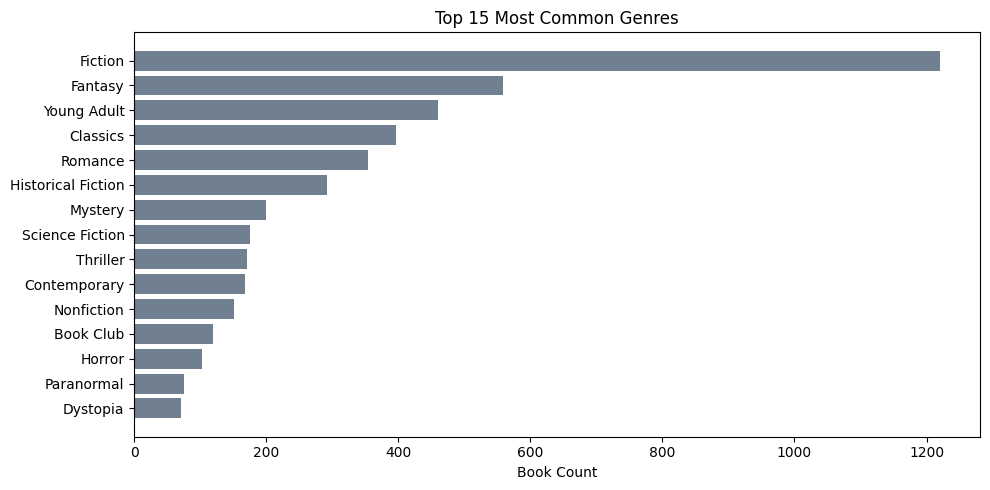

In [69]:
genre_counter = Counter()
for genre_list in df["genres"].dropna():
    for g in [x.strip() for x in genre_list.split(",")]:
        genre_counter[g] += 1

# Show top 15 genres
top_genres = genre_counter.most_common(15)
for genre, count in top_genres:
    print(f"{genre:<20} {count}")

genres, counts = zip(*top_genres)

plt.figure(figsize=(10, 5))
plt.barh(genres[::-1], counts[::-1], color = "slategrey")
plt.title("Top 15 Most Common Genres")
plt.xlabel("Book Count")
plt.tight_layout()
plt.show()

**Transforming**

In [5]:
#transformations
#removing duplicates
df_mod = (df.sort_values("rating_count", ascending=False).drop_duplicates(subset=["title", "author"]))
df_mod["log_rating_count"] = np.log1p(df_mod["rating_count"])
df_mod["log_num_pages"] = np.log1p(df_mod["num_pages"])
df_mod["log_pub_age"] = np.log1p(2025 - df_mod["pub_year"])

In [14]:
#sklearn knn classifier model
use_cols = ['log_rating_count', 'log_num_pages',
            'log_pub_age', 'avg_rating']

df_mod['genres_txt'] = df_mod['genres'].str.replace(',', ' ')

full_pre = ColumnTransformer([
    ('genres',  TfidfVectorizer(min_df=2), 'genres_txt'),
    ('author',  TfidfVectorizer(min_df=2), 'author'),
    ('numeric', RobustScaler(),            use_cols)
])

model = Pipeline([
    ('prep', full_pre),
    ('knn',  NearestNeighbors(metric='cosine', n_neighbors=11))
])

model.fit(df_mod)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('genres',
                                                  TfidfVectorizer(min_df=2),
                                                  'genres_txt'),
                                                 ('author',
                                                  TfidfVectorizer(min_df=2),
                                                  'author'),
                                                 ('numeric', RobustScaler(),
                                                  ['log_rating_count',
                                                   'log_num_pages',
                                                   'log_pub_age',
                                                   'avg_rating'])])),
                ('knn', NearestNeighbors(metric='cosine', n_neighbors=11))])

In [ ]:
#saving tranformed dataset
df_mod.to_csv("/Users/setaranusratty/Desktop/data.csv", index=False)

In [16]:
#model cont
def recommend(title, k=5):
    """
    Return k content-based recommendations for the given book *title*.
    Case-insensitive exact-title match; adjust if you need fuzzy search.
    """
    # — locate the row for the query book
    idx_list = df_mod.index[df_mod['title'].str.lower() == title.lower()]
    if len(idx_list) == 0:
        raise ValueError(f'"{title}" not found in DataFrame.')

    idx = idx_list[0]
    
    # — vectorise that single row
    vec = model['prep'].transform(df_mod.iloc[[idx]])
    
    # — ask k-NN for the k+1 nearest rows (first hit = itself)
    dists, nbr_idx = model['knn'].kneighbors(vec, n_neighbors=k+1)
    
    # — build a tidy DataFrame of recs
    recs = (df_mod
            .iloc[nbr_idx[0][1:]]                # skip row 0 (identity)
            [['title', 'author', 'avg_rating']]
            .assign(similarity=1 - dists[0][1:]) # cosine sim = 1 − distance
            .reset_index(drop=True))
    return recs

In [18]:
#testing classifier 
recommend("The Hunger Games")

,title,author,avg_rating,similarity
0,Harry Potter and the Chamber of Secrets,J.K. Rowling,4.43,0.993281
1,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,4.58,0.964469
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,4.58,0.866167
3,Harry Potter and the Goblet of Fire,J.K. Rowling,4.57,0.847039
4,Catching Fire,Suzanne Collins,4.34,0.838153


In [46]:
joblib.dump(model, "book_knn_model.pkl")

['book_knn_model.pkl']